# Clustering
Comenzaremos identificando las variables valiosas para nuestra predicción

In [59]:
import pandas as pd 
rsv = pd.read_csv("/Users/manuelrodriguez/Documents/Proyectos/Clustera/Data/Reservaciones.csv")
rsv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102154 entries, 0 to 102153
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ID_Reserva              102154 non-null  int64  
 1   Fecha_hoy               102154 non-null  object 
 2   h_num_per               102154 non-null  int64  
 3   h_num_adu               102154 non-null  int64  
 4   h_num_men               102154 non-null  int64  
 5   h_num_noc               102154 non-null  int64  
 6   h_tot_hab               102154 non-null  int64  
 7   ID_Tipo_Habitacion      102154 non-null  int64  
 8   ID_Pais_Origen          102154 non-null  int64  
 9   h_edo                   102154 non-null  object 
 10  h_tfa_total             102154 non-null  float64
 11  moneda_cve              102154 non-null  int64  
 12  Hotel_cve               102154 non-null  object 
 13  Agencia_nombre          102154 non-null  object 
 14  Estado_cve          

Las preprocesamos

In [50]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

cols_clustering = ['h_num_adu', 'h_num_men', 'h_num_noc', 'Clasificacion', 'Estado_cve', 'Paquete_nombre']

rsv_clustering = rsv[cols_clustering].copy()
rsv_clustering.dropna(inplace=True)

num_features = ['h_num_adu', 'h_num_men', 'h_num_noc']
cat_features = ['Clasificacion', 'Estado_cve', 'Paquete_nombre']

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), cat_features)
])

X_scaled = preprocessor.fit_transform(rsv_clustering)

Identificamos el número de Clusters inicial

/Users/manuelrodriguez/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/manuelrodriguez/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/manuelrodriguez/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/manuelrodriguez/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

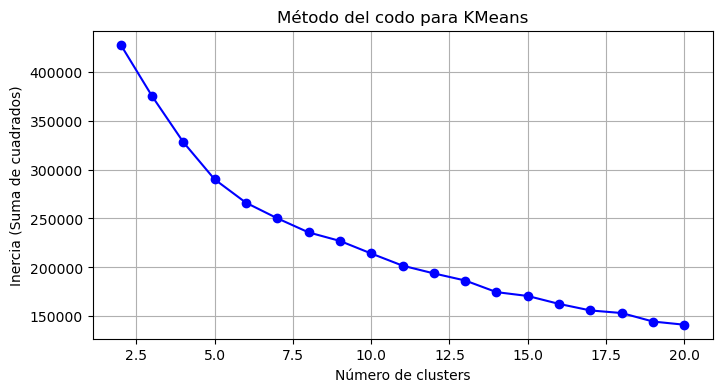

In [51]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K_range = range(2, 21)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia (Suma de cuadrados)')
plt.title('Método del codo para KMeans')
plt.grid(True)
plt.show()

In [52]:
optimal_k = 5
kmeans_pp = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
labels_kmeans_pp = kmeans_pp.fit_predict(X_scaled)

/Users/manuelrodriguez/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [53]:
# Asignamos las etiquetas del modelo a tu dataset preprocesado
rsv_clustering['cluster'] = kmeans_pp.labels_

In [54]:
cluster_summary = rsv_clustering.groupby('cluster')[['h_num_adu', 'h_num_men', 'h_num_noc']].mean()

paquete_frecuente = rsv_clustering.groupby('cluster')['Paquete_nombre'].agg(lambda x: x.mode()[0])
estado_frecuente = rsv_clustering.groupby('cluster')['Estado_cve'].agg(lambda x: x.mode()[0])

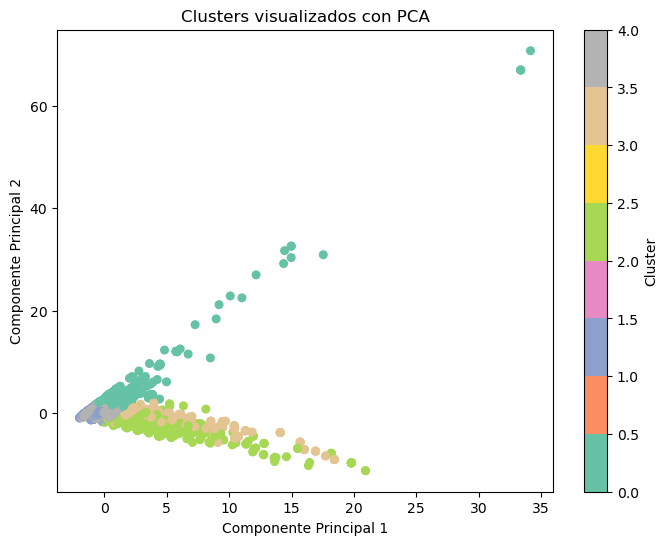

In [55]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)  # Usar datos escalados


plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_pp.labels_, cmap='Set2', s=30)
plt.title("Clusters visualizados con PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label="Cluster")
plt.show()

Guardaremos el pipeline de preprocesamiento y clusterizado

In [56]:
import joblib

joblib.dump(preprocessor, "/Users/manuelrodriguez/Documents/Proyectos/Clustera/Outputs/preprocessor.pkl")
joblib.dump(kmeans_pp, "/Users/manuelrodriguez/Documents/Proyectos/Clustera/Outputs/clustering.pkl")

['/Users/manuelrodriguez/Documents/Proyectos/Clustera/Outputs/clustering.pkl']

In [61]:
import pandas as pd
import joblib

preprocessor = joblib.load("/Users/manuelrodriguez/Documents/Proyectos/Clustera/Outputs/preprocessor.pkl")
kmeans_model = joblib.load("/Users/manuelrodriguez/Documents/Proyectos/Clustera/Outputs/clustering.pkl")

# Simularemos entradas de un cliente
# que no está en el dataset original
new_input = pd.DataFrame([{
    "h_num_adu": 2,
    "h_num_men": 0,
    "h_num_noc": 3,
    "Estado_cve": "EQR",
    "Clasificacion": "",  # Variable a predecir
    "Paquete_nombre": ""  # Variable a predecir
}])

# Solo para usar el preprocessor (no se usarán estos campos como input directo)
input_for_transform = new_input.copy()

X_new = preprocessor.transform(input_for_transform)

predicted_cluster = kmeans_model.predict(X_new)[0]

# Filtrar el dataset original por ese cluster
matching_cluster = rsv_clustering[rsv_clustering['cluster'] == predicted_cluster]

# Elegir la moda del tipo de habitación y nombre del paquete
recommended_room = matching_cluster['Clasificacion'].mode()[0]
recommended_package = matching_cluster['Paquete_nombre'].mode()[0]

print(f"Cluster Asociado:")
print(f"Clasificacion: {recommended_room}")
print(f"Paquete_nombre: {recommended_package}")

Cluster Asociado:
Clasificacion: GSU
Paquete_nombre: WALK IN
